# 1. Load Libraries

In [562]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
# custom libraries
import db_manager as db
import ticker

# 1. Data Pre-Processing

In [501]:
conn = db.connectToDB()
df = db.getDailyPrices(1,conn=conn)

Connecting to the PostgreSQL database...


In [502]:
# View df
df

,date,ticker,open,close,low,high,volume
0,2013-01-02,AAPL,19.779285,19.608213,19.821428,19.343929,560518000.0
1,2013-01-03,AAPL,19.567142,19.360714,19.631071,19.321428,352965180.0
2,2013-01-04,AAPL,19.177500,18.821428,19.236786,18.779642,594333570.0
3,2013-01-07,AAPL,18.642857,18.710714,18.903570,18.400000,484156420.0
4,2013-01-08,AAPL,18.900356,18.761070,18.996071,18.616072,458707200.0
...,...,...,...,...,...,...,...
2584,2023-04-10,AAPL,161.419998,162.029999,162.029999,160.080002,47716900.0
2585,2023-04-11,AAPL,162.350006,160.800003,162.360001,160.509995,47644200.0
2586,2023-04-12,AAPL,161.220001,160.100006,162.059998,159.779999,50133100.0
2587,2023-04-13,AAPL,161.630005,165.559998,165.800003,161.419998,68445600.0


In [503]:
# Keep only close
df2 = df['close']
df2

0        19.608213
1        19.360714
2        18.821428
3        18.710714
4        18.761070
           ...    
2584    162.029999
2585    160.800003
2586    160.100006
2587    165.559998
2588    165.210007
Name: close, Length: 2589, dtype: float64

In [504]:
df2.shape

(2589,)

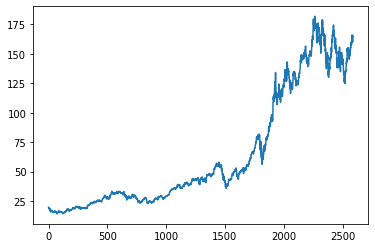

In [505]:
# plot
plt.plot(df2)

In [506]:
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))

In [507]:
df2

array([[0.03368219],
       [0.03220953],
       [0.02900069],
       ...,
       [0.86963189],
       [0.90211976],
       [0.90003726]])

In [508]:
df2.shape

(2589, 1)

In [509]:
train_size = int(len(df2)*0.65)
test_size=len(df2)-train_size
train_data, test_data=df2[0:train_size,:],df2[train_size:len(df2),:1]

In [510]:
train_size,test_size

(1682, 907)

In [511]:
# convert an array of values into dataset matrix
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step),0])
        Y.append(dataset[i+time_step,0])
    return np.array(X), np.array(Y)

In [512]:
TIME_STEP=60
X_train, y_train = create_dataset(train_data,TIME_STEP)
X_test, y_test = create_dataset(test_data, TIME_STEP)

In [513]:
print(X_train)

[[0.03368219 0.03220953 0.02900069 ... 0.01500505 0.01307974 0.01107794]
 [0.03220953 0.02900069 0.02834192 ... 0.01307974 0.01107794 0.00815598]
 [0.02900069 0.02834192 0.02864155 ... 0.01107794 0.00815598 0.00834299]
 ...
 [0.19986612 0.20348085 0.20679807 ... 0.22274452 0.22792116 0.22751954]
 [0.20348085 0.20679807 0.2058758  ... 0.22792116 0.22751954 0.2229974 ]
 [0.20679807 0.2058758  0.20581628 ... 0.22751954 0.2229974  0.22818893]]


In [514]:
print(X_train.shape)
print(X_test.shape)

(1621, 60)
(846, 60)


In [515]:
# Reshape to include additional dimension
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [516]:
print(X_train.shape)
print(X_test.shape)
print(X_train)

(1621, 60, 1)
(846, 60, 1)
[[[0.03368219]
  [0.03220953]
  [0.02900069]
  ...
  [0.01500505]
  [0.01307974]
  [0.01107794]]

 [[0.03220953]
  [0.02900069]
  [0.02834192]
  ...
  [0.01307974]
  [0.01107794]
  [0.00815598]]

 [[0.02900069]
  [0.02834192]
  [0.02864155]
  ...
  [0.01107794]
  [0.00815598]
  [0.00834299]]

 ...

 [[0.19986612]
  [0.20348085]
  [0.20679807]
  ...
  [0.22274452]
  [0.22792116]
  [0.22751954]]

 [[0.20348085]
  [0.20679807]
  [0.2058758 ]
  ...
  [0.22792116]
  [0.22751954]
  [0.2229974 ]]

 [[0.20679807]
  [0.2058758 ]
  [0.20581628]
  ...
  [0.22751954]
  [0.2229974 ]
  [0.22818893]]]


# 2. LSTM Model Architecture

In [517]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(TIME_STEP,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [518]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_30 (LSTM)              (None, 60, 50)            20200     
                                                                 
 lstm_31 (LSTM)              (None, 50)                20200     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


# 3. Training

In [519]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 [==============================] - 5s 101ms/step - loss: 0.0019 - val_loss: 0.0155
Epoch 2/100
26/26 [==============================] - 2s 76ms/step - loss: 1.7880e-04 - val_loss: 0.0118
Epoch 3/100
26/26 [==============================] - 2s 77ms/step - loss: 1.1137e-04 - val_loss: 0.0108
Epoch 4/100
26/26 [==============================] - 2s 78ms/step - loss: 1.0198e-04 - val_loss: 0.0090
Epoch 5/100
26/26 [==============================] - 2s 81ms/step - loss: 9.6062e-05 - val_loss: 0.0116
Epoch 6/100
26/26 [==============================] - 2s 82ms/step - loss: 9.6238e-05 - val_loss: 0.0102
Epoch 7/100
26/26 [==============================] - 2s 84ms/step - loss: 8.9116e-05 - val_loss: 0.0070
Epoch 8/100
26/26 [==============================] - 2s 76ms/step - loss: 8.7959e-05 - val_loss: 0.0074
Epoch 9/100
26/26 [==============================] - 2s 82ms/step - loss: 8.1523e-05 - val_loss: 0.0107
Epoch 10/100
26/26 [==============================] - 2s 80ms/step 

26/26 [==============================] - 2s 79ms/step - loss: 2.5540e-05 - val_loss: 0.0058
Epoch 80/100
26/26 [==============================] - 2s 72ms/step - loss: 2.1662e-05 - val_loss: 0.0062
Epoch 81/100
26/26 [==============================] - 2s 82ms/step - loss: 2.0047e-05 - val_loss: 0.0055
Epoch 82/100
26/26 [==============================] - 2s 87ms/step - loss: 2.7144e-05 - val_loss: 0.0025
Epoch 83/100
26/26 [==============================] - 2s 77ms/step - loss: 2.4681e-05 - val_loss: 0.0051
Epoch 84/100
26/26 [==============================] - 2s 75ms/step - loss: 2.3530e-05 - val_loss: 0.0055
Epoch 85/100
26/26 [==============================] - 2s 80ms/step - loss: 2.1674e-05 - val_loss: 0.0073
Epoch 86/100
26/26 [==============================] - 2s 80ms/step - loss: 1.9110e-05 - val_loss: 0.0040
Epoch 87/100
26/26 [==============================] - 2s 83ms/step - loss: 2.0655e-05 - val_loss: 0.0052
Epoch 88/100
26/26 [==============================] - 2s 80ms/step -

In [520]:
import tensorflow as tf

In [521]:
tf.__version__

'2.10.0'

# 4. Prediction

In [522]:
X_train

array([[[0.03368219],
        [0.03220953],
        [0.02900069],
        ...,
        [0.01500505],
        [0.01307974],
        [0.01107794]],

       [[0.03220953],
        [0.02900069],
        [0.02834192],
        ...,
        [0.01307974],
        [0.01107794],
        [0.00815598]],

       [[0.02900069],
        [0.02834192],
        [0.02864155],
        ...,
        [0.01107794],
        [0.00815598],
        [0.00834299]],

       ...,

       [[0.19986612],
        [0.20348085],
        [0.20679807],
        ...,
        [0.22274452],
        [0.22792116],
        [0.22751954]],

       [[0.20348085],
        [0.20679807],
        [0.2058758 ],
        ...,
        [0.22792116],
        [0.22751954],
        [0.2229974 ]],

       [[0.20679807],
        [0.2058758 ],
        [0.20581628],
        ...,
        [0.22751954],
        [0.2229974 ],
        [0.22818893]]])

In [523]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

27/27 [==============================] - 0s 10ms/step


In [524]:
# Transform
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [525]:
train_predict

array([[16.013561],
       [15.697628],
       [15.419041],
       ...,
       [51.260094],
       [51.258385],
       [51.371346]], dtype=float32)

In [526]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

33.67747445863915

In [527]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

119.62119254506683

# 5. Comparing (Plotting)

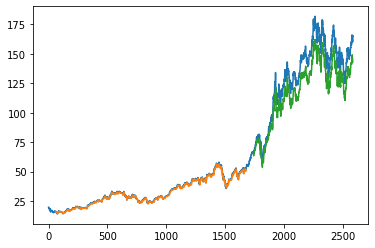

In [528]:
LOOK_BACK=60
# plotting
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[LOOK_BACK:len(train_predict)+LOOK_BACK,:] = train_predict
#Shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(LOOK_BACK*2)+1:len(df2)-1,:] = test_predict
# Plotting
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [529]:
len(test_data)

907

In [530]:
train_predict

array([[16.013561],
       [15.697628],
       [15.419041],
       ...,
       [51.260094],
       [51.258385],
       [51.371346]], dtype=float32)

# 6. Future Prediction 

In [531]:
test_data

array([[0.23559688],
       [0.23936036],
       [0.24960952],
       [0.24886575],
       [0.24240982],
       [0.24412049],
       [0.24531053],
       [0.24838975],
       [0.2456973 ],
       [0.24089253],
       [0.2423652 ],
       [0.24081814],
       [0.24580142],
       [0.24410562],
       [0.24251396],
       [0.25017479],
       [0.25109706],
       [0.24272222],
       [0.24548905],
       [0.25469691],
       [0.25477129],
       [0.25081442],
       [0.25472667],
       [0.25927854],
       [0.26838232],
       [0.26787654],
       [0.26705841],
       [0.26564522],
       [0.26699889],
       [0.26867982],
       [0.27477873],
       [0.2739606 ],
       [0.27875046],
       [0.27934549],
       [0.28380812],
       [0.28748235],
       [0.27891409],
       [0.27886947],
       [0.28705095],
       [0.29755301],
       [0.30005207],
       [0.29950169],
       [0.2996653 ],
       [0.30292302],
       [0.30397921],
       [0.30704354],
       [0.3066865 ],
       [0.310

In [532]:
test_data.shape

(907, 1)

In [533]:
# Use only last 60 days
i = len(test_data)-LOOK_BACK
x_input = test_data[i:].reshape(1,-1)
x_input

array([[0.72188922, 0.73735961, 0.75663818, 0.76508741, 0.76110081,
        0.7735962 , 0.78531794, 0.76788399, 0.77555967, 0.78234286,
        0.81441435, 0.83631092, 0.81982893, 0.83720341, 0.82095948,
        0.81471178, 0.81554481, 0.83244335, 0.82857569, 0.84124957,
        0.83161033, 0.82470811, 0.80049089, 0.80304951, 0.80596503,
        0.78995916, 0.79715881, 0.79412426, 0.78162887, 0.78519901,
        0.81566383, 0.83232432, 0.81905547, 0.82661212, 0.81304574,
        0.80060992, 0.81233175, 0.82494608, 0.8273262 , 0.84434368,
        0.839286  , 0.85356637, 0.86475272, 0.85612499, 0.86267012,
        0.87052438, 0.85880255, 0.85505391, 0.8736185 , 0.88307924,
        0.89819263, 0.90574936, 0.90253632, 0.89140944, 0.89676465,
        0.88111568, 0.87379699, 0.86963189, 0.90211976, 0.90003726]])

In [534]:
x_input.shape

(1, 60)

In [535]:
temp_input = list(x_input)
temp_input

[array([0.72188922, 0.73735961, 0.75663818, 0.76508741, 0.76110081,
        0.7735962 , 0.78531794, 0.76788399, 0.77555967, 0.78234286,
        0.81441435, 0.83631092, 0.81982893, 0.83720341, 0.82095948,
        0.81471178, 0.81554481, 0.83244335, 0.82857569, 0.84124957,
        0.83161033, 0.82470811, 0.80049089, 0.80304951, 0.80596503,
        0.78995916, 0.79715881, 0.79412426, 0.78162887, 0.78519901,
        0.81566383, 0.83232432, 0.81905547, 0.82661212, 0.81304574,
        0.80060992, 0.81233175, 0.82494608, 0.8273262 , 0.84434368,
        0.839286  , 0.85356637, 0.86475272, 0.85612499, 0.86267012,
        0.87052438, 0.85880255, 0.85505391, 0.8736185 , 0.88307924,
        0.89819263, 0.90574936, 0.90253632, 0.89140944, 0.89676465,
        0.88111568, 0.87379699, 0.86963189, 0.90211976, 0.90003726])]

In [536]:
temp_input = temp_input[0].tolist()
temp_input

[0.7218892234106128,
 0.7373596054253507,
 0.7566381839089085,
 0.7650874098947537,
 0.7611008095530177,
 0.773596197057529,
 0.7853179437803776,
 0.7678839945818964,
 0.7755596690385919,
 0.782342860017638,
 0.8144143462823159,
 0.8363109211249065,
 0.8198289332786591,
 0.8372034105527232,
 0.8209594770088352,
 0.8147117832565796,
 0.8155448067101467,
 0.8324433479343503,
 0.828575685491281,
 0.8412495720713893,
 0.8316103304309506,
 0.8247081123007247,
 0.800490888820852,
 0.8030495084581482,
 0.8059650310439577,
 0.7899591577525966,
 0.7971588069069186,
 0.7941242571699294,
 0.7816288696654182,
 0.7851990058817107,
 0.8156638338613263,
 0.8323243207831705,
 0.8190554710020221,
 0.8266121183075378,
 0.813045742299613,
 0.8006099159720317,
 0.812331751947393,
 0.8249460773505713,
 0.8273261979122706,
 0.8443436829853085,
 0.839286004887646,
 0.8535663712477908,
 0.8647527159465292,
 0.8561249908850871,
 0.8626701216116064,
 0.8705243843964116,
 0.8588025484210501,
 0.8550539131291606,

In [537]:
def predictUpcomingDays(stock_prices,numOfDays=5,look_back=60):
    
    # Use only last 60 days
    i = len(stock_prices)-LOOK_BACK
    x_input = stock_prices[i:].reshape(1,-1)
    temp_input = list(x_input)
    temp_input = temp_input[0].tolist()
    
    lst_output=[]
    n_steps=look_back
    i=0
    while(i<numOfDays):
        if(len(temp_input)>look_back):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    
    results = scaler.inverse_transform(lst_output)
    results = results.reshape(1,-1).tolist()[0]
    return results

In [538]:
results = predictUpcomingDays(test_data)

[0.7998295]
61
1 day input [0.73735961 0.75663818 0.76508741 0.76110081 0.7735962  0.78531794
 0.76788399 0.77555967 0.78234286 0.81441435 0.83631092 0.81982893
 0.83720341 0.82095948 0.81471178 0.81554481 0.83244335 0.82857569
 0.84124957 0.83161033 0.82470811 0.80049089 0.80304951 0.80596503
 0.78995916 0.79715881 0.79412426 0.78162887 0.78519901 0.81566383
 0.83232432 0.81905547 0.82661212 0.81304574 0.80060992 0.81233175
 0.82494608 0.8273262  0.84434368 0.839286   0.85356637 0.86475272
 0.85612499 0.86267012 0.87052438 0.85880255 0.85505391 0.8736185
 0.88307924 0.89819263 0.90574936 0.90253632 0.89140944 0.89676465
 0.88111568 0.87379699 0.86963189 0.90211976 0.90003726 0.79982948]
1 day output [[0.73746604]]
2 day input [0.75663818 0.76508741 0.76110081 0.7735962  0.78531794 0.76788399
 0.77555967 0.78234286 0.81441435 0.83631092 0.81982893 0.83720341
 0.82095948 0.81471178 0.81554481 0.83244335 0.82857569 0.84124957
 0.83161033 0.82470811 0.80049089 0.80304951 0.80596503 0.7899

In [540]:
results = results.reshape(1,-1).tolist()[0]

AttributeError: 'list' object has no attribute 'reshape'

In [541]:
results

[148.36883849295617,
 137.88788220193177,
 124.7033854314819,
 110.85859798122407,
 96.92141591539756]

# 7. Saving Model

In [542]:
import joblib
model.save('AAPL')
joblib.dump(scaler, 'scaler.gz')
scaler = joblib.load('scaler.gz')

INFO:tensorflow:Assets written to: AAPL/assets


INFO:tensorflow:Assets written to: AAPL/assets


In [543]:
model = None
model = tf.keras.models.load_model('AAPL')
results = predictUpcomingDays(test_data)
results

[0.7998295]
61
1 day input [0.73735961 0.75663818 0.76508741 0.76110081 0.7735962  0.78531794
 0.76788399 0.77555967 0.78234286 0.81441435 0.83631092 0.81982893
 0.83720341 0.82095948 0.81471178 0.81554481 0.83244335 0.82857569
 0.84124957 0.83161033 0.82470811 0.80049089 0.80304951 0.80596503
 0.78995916 0.79715881 0.79412426 0.78162887 0.78519901 0.81566383
 0.83232432 0.81905547 0.82661212 0.81304574 0.80060992 0.81233175
 0.82494608 0.8273262  0.84434368 0.839286   0.85356637 0.86475272
 0.85612499 0.86267012 0.87052438 0.85880255 0.85505391 0.8736185
 0.88307924 0.89819263 0.90574936 0.90253632 0.89140944 0.89676465
 0.88111568 0.87379699 0.86963189 0.90211976 0.90003726 0.79982948]
1 day output [[0.73746604]]
2 day input [0.75663818 0.76508741 0.76110081 0.7735962  0.78531794 0.76788399
 0.77555967 0.78234286 0.81441435 0.83631092 0.81982893 0.83720341
 0.82095948 0.81471178 0.81554481 0.83244335 0.82857569 0.84124957
 0.83161033 0.82470811 0.80049089 0.80304951 0.80596503 0.7899

[148.36883849295617,
 137.88788220193177,
 124.7033854314819,
 110.85859798122407,
 96.92141591539756]

In [544]:
# 8. Sav

In [565]:
train_predict

array([[0.0044504 ],
       [0.00406859],
       [0.00323792],
       ...,
       [0.05778539],
       [0.0564747 ],
       [0.05797967]], dtype=float32)

In [566]:
test_predict

array([[0.06013394],
       [0.06123143],
       [0.06423051],
       [0.06401237],
       [0.06212219],
       [0.06262245],
       [0.06297073],
       [0.06387281],
       [0.06308395],
       [0.0616788 ],
       [0.06210914],
       [0.06165709],
       [0.06311442],
       [0.06261809],
       [0.06215262],
       [0.06439635],
       [0.06466703],
       [0.06221351],
       [0.06302298],
       [0.06572472],
       [0.0657466 ],
       [0.06458408],
       [0.06573348],
       [0.06707352],
       [0.0697623 ],
       [0.06961261],
       [0.06937058],
       [0.06895269],
       [0.06935297],
       [0.06985037],
       [0.07165834],
       [0.07141554],
       [0.07283851],
       [0.0730155 ],
       [0.07434445],
       [0.07544064],
       [0.07288718],
       [0.07287391],
       [0.07531185],
       [0.07845451],
       [0.07920451],
       [0.07903926],
       [0.07908838],
       [0.08006713],
       [0.08038476],
       [0.08130711],
       [0.0811996 ],
       [0.082

In [567]:
train_predict.shape
train_predict_reshaped = train_predict.reshape(1,train_predict.shape[0]).tolist()[0]
test_predict_reshaped = test_predict.reshape(1,test_predict.shape[0]).tolist()[0]
all_preds = train_predict_reshaped + test_predict_reshaped
print(len(all_preds))
#print(all_preds)
print(len(train_predict_reshaped))
print(len(test_predict_reshaped))

2585
1680
905


In [548]:
df

,date,ticker,open,close,low,high,volume
0,2013-01-02,AAPL,19.779285,19.608213,19.821428,19.343929,560518000.0
1,2013-01-03,AAPL,19.567142,19.360714,19.631071,19.321428,352965180.0
2,2013-01-04,AAPL,19.177500,18.821428,19.236786,18.779642,594333570.0
3,2013-01-07,AAPL,18.642857,18.710714,18.903570,18.400000,484156420.0
4,2013-01-08,AAPL,18.900356,18.761070,18.996071,18.616072,458707200.0
...,...,...,...,...,...,...,...
2584,2023-04-10,AAPL,161.419998,162.029999,162.029999,160.080002,47716900.0
2585,2023-04-11,AAPL,162.350006,160.800003,162.360001,160.509995,47644200.0
2586,2023-04-12,AAPL,161.220001,160.100006,162.059998,159.779999,50133100.0
2587,2023-04-13,AAPL,161.630005,165.559998,165.800003,161.419998,68445600.0


In [549]:
df.shape

(2589, 7)

In [550]:
print(len(all_preds)+60+60)

2587


In [551]:
X_train2, y_train2 = create_dataset(train_data,1)
X_test2, y_test2 = create_dataset(test_data, 1)

In [552]:
# Reshape to include additional dimension
X_train2 = X_train2.reshape(X_train2.shape[0],X_train2.shape[1],1)
X_test2 = X_test2.reshape(X_test2.shape[0],X_test2.shape[1],1)

In [553]:
train_predict = model.predict(X_train2)
test_predict = model.predict(X_test2)

29/29 [==============================] - 0s 851us/step


In [554]:
train_predict.shape
train_predict_reshaped = train_predict.reshape(1,train_predict.shape[0]).tolist()[0]
test_predict_reshaped = test_predict.reshape(1,test_predict.shape[0]).tolist()[0]
all_preds = train_predict_reshaped + test_predict_reshaped
print(len(all_preds))
#print(all_preds)
print(len(train_predict_reshaped))
print(len(test_predict_reshaped))

2585
1680
905


In [555]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train2,train_predict))

0.09582496742050065

In [556]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test2,test_predict))

0.4891437714005259

In [557]:
len(test_predict)

905

In [558]:
df.shape

(2589, 7)

In [559]:
df3 = df['date']
df3 = df3[df3.shape[0]-len(test_predict):df3.shape[0]]
df3

1684    2019-09-11
1685    2019-09-12
1686    2019-09-13
1687    2019-09-16
1688    2019-09-17
           ...    
2584    2023-04-10
2585    2023-04-11
2586    2023-04-12
2587    2023-04-13
2588    2023-04-14
Name: date, Length: 905, dtype: object

In [563]:
conn = db.connectToDB()

Connecting to the PostgreSQL database...


In [564]:
count = 0;
for date in df3:
    db.insertPrediction(date,'AAPL',test_predict[count],conn)
    count+=1

AttributeError: module 'db_manager' has no attribute 'insertPrediction'